In [1]:
'''
Windows: Open Anaconda prompt
conda create --name tigre_env -c anaconda -c ccpi -c conda-forge  python tigre simpleitk ipykernel opencv astropy tomopy nibabel scikit-image scikit-learn scipy tqdm scikit-learn-intelex jupyter ipywidgets
conda activate tigre_env

conda list --export > conda-package-list.txt
conda create -n tigre_env --file conda-package-list.txt
'''

import json
import math
import multiprocessing
import os
import sys
from __future__ import division


import cv2
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import SimpleITK as sitk
import tomopy
from copy import copy
from astropy.convolution import Gaussian2DKernel, interpolate_replace_nans
from PIL import Image
from scipy import interpolate
from scipy.ndimage import median_filter
from scipy.signal import medfilt2d
from skimage.registration import phase_cross_correlation
from tqdm import trange, tqdm
from typing import List
import SimpleITK as sitk
import datetime


import tigre
import tigre.algorithms as algs
from tigre.utilities.geometry import Geometry

import shared_functions as s


def plot_image(arr, title='', vmin=None, vmax=None):
    cm = copy(plt.cm.viridis)
    plt.figure(figsize=(20,20))
    plt.title(title)
    im = plt.imshow(arr, vmin=vmin, vmax=vmax, cmap=cm, interpolation='none')
    im.cmap.set_under('b')
    im.cmap.set_over('r')
    im.cmap.set_bad('pink')
    plt.colorbar()
    plt.show()

drive = 'f:\\'
# basefolder = os.path.join(drive,'jasper','data','20220726_scanseries')
# base_folder = os.path.join(drive, 'jasper', 'data', '20220822_ffpe_WhateverBreast')
# base_folder = os.path.join(drive, 'jasper', 'data', '20220825_LegoMan')
# base_folder = os.path.join(drive, 'jasper', 'data', '20220822_Al_Phantom_Recon_Alignment')
# base_folder = os.path.join(drive, 'jasper', 'data', '20220822_ffpe_WhateverBreast')
# base_folder = os.path.join(drive, 'jasper', 'data', '20220805_tumourWhateverBreast')
# base_folder = os.path.join(drive, 'jasper', 'data', '20220727_HamnCheeseseries_M')
# base_folder = os.path.join(drive, 'jasper', 'data', '20220929_Legoman_al_filter_110_um_variable_exposures')
# base_folder = os.path.join(drive, 'jasper', 'data', '20220930_Legoman_al_filter_110_um_fixed_exposures')
# base_folder = os.path.join(drive, 'jasper', 'data', '20221003_Legoman_al_filter_110_um') # centre_of_rotation_offset_x_mm = 0.1
# base_folder = os.path.join(drive, 'jasper', 'data', '20221004_Legoman_al_filter_220_um') # 4 keV only
# base_folder = os.path.join(drive, 'jasper', 'data', '20221004_Legoman_al_filter_220_um') # 4 keV only
# base_folder = os.path.join(drive, 'jasper', 'data', '20221004_Legoman_al_filter_500_um') # centre_of_rotation_offset_x_mm = -0.0275
# base_folder = os.path.join(drive, 'jasper', 'data', '20221010_New_detector_move') # centre_of_rotation_offset_x_mm = 0.01
# base_folder = os.path.join(drive, 'jasper', 'data', '20221010_old_detector_move') # centre_of_rotation_offset_x_mm = 0.12
base_folder = os.path.join(drive, 'jasper', 'data', '20221110_HamNCheese_500_um_Al_filter'); centre_of_rotation_offset_x_mm = 0.1
# base_folder = os.path.join(drive, 'jasper', 'data', '20221011_HamNChesse_New_motion')# centre_of_rotation_offset_x_mm = 0.22


base_json_file = os.path.join(base_folder, 'scan_settings.json')
results_folder = os.path.join(base_folder, 'results')
if not os.path.exists(results_folder):
    os.makedirs(results_folder)

chip_indices = (0,1,2,3)

# Make a list of globals for the reconstruction setting, and log them in a json file
gReconParams = dict()

gReconParams['pixels'] = 512  # (pixels)
gReconParams['pixel_pitch'] = 0.055  # (mm)
gReconParams['fill_gap'] = True
gReconParams['median_filter'] = False
gReconParams['bad_pixel_correction'] = True
gReconParams['recon_voxels'] = (
    gReconParams['pixels'], gReconParams['pixels'], gReconParams['pixels'])  # number of voxels (vx)
 
'''
9.5+9+30+100+30+9+9+0.055+1.035 = 197.59 mm

9.5 mm   - Tube focal spot to tube face
9 mm     - Edge of tube to the sample stage edge
30 mm    - Radius of the sample stage
100 mm   - Sample stage maximum range (variable for magnified scans - TODO implement this...)
30 mm    - Radius of the sample stage
9 mm     - Edge of sample stage to detector face (not mylar)
9 mm     - Detector face to mylar 
0.055 mm - Mylar cover thickness
1.035 mm - Mylar to Si sensor surface
'''
gReconParams['distance_source_detector'] = 197.59
gReconParams['z_stage_distance_mm'] = s.get_sample_z_from_first_scan_json(base_json_file) # Varies between 0 and 100 mm
print(gReconParams['z_stage_distance_mm'])
'''
30 mm    - Radius of the sample stage
9 mm     - Edge of sample stage to detector face (not mylar)
9 mm     - Detector face to mylar 
0.055 mm - Mylar cover thickness
1.035 mm - Mylar to Si sensor surface
'''
gReconParams['distance_object_detector'] = 30 + \
    gReconParams['z_stage_distance_mm'] + 9+9+0.055+1.035  # (mm)
gReconParams['detector_rotation'] = (math.radians(0.), 0., 0.)  # (mm)

assert gReconParams['z_stage_distance_mm'] < 100 and gReconParams['z_stage_distance_mm'] >= 0


DSD = gReconParams['distance_source_detector']
DSO = DSD - gReconParams['distance_object_detector']
a = gReconParams['pixels'] * gReconParams['pixel_pitch'] / (((DSD-DSO) / DSO) + 1)
gReconParams['recon_size'] = (a, a, a)
# gReconParams['recon_size'] = (512*0.055,512*0.055,512*0.055)

print(gReconParams)

# 20220805_tumourWhateverBreast
# centre_of_rotation_offset_x_mm = -0.27  # s.find_optimal_offset(gReconParams, spectral_projs_th0[1, :, :, :], angles, detector_x_offsets, detector_y_offsets, stage_offset=0, search_range=25)
# centre_of_rotation_offset_y_mm = -0.24

# 20220822_ffpe_WhateverBreast
# centre_of_rotation_offset_x_mm = 0.16885  # s.find_optimal_offset(gReconParams, spectral_projs_th0[1, :, :, :], angles, detector_x_offsets, detector_y_offsets, stage_offset=0, search_range=25)
# centre_of_rotation_offset_y_mm = 0.0

# 20220727_HamnCheeseseries_M
# centre_of_rotation_offset_x_mm = 0.04)  # s.find_optimal_offset(gReconParams, spectral_projs_th0[1, :, :, :], angles, detector_x_offsets, detector_y_offsets, stage_offset=0, search_range=25)

centre_of_rotation_offset_x_mm = float(centre_of_rotation_offset_x_mm)
centre_of_rotation_offset_y_mm = float(0)

print(f'centre_of_rotation_offset_x_mm = {centre_of_rotation_offset_x_mm} (mm)')
print(f'centre_of_rotation_offset_y_mm = {centre_of_rotation_offset_y_mm} (mm)')

10.0
{'pixels': 512, 'pixel_pitch': 0.055, 'fill_gap': True, 'median_filter': False, 'bad_pixel_correction': True, 'recon_voxels': (512, 512, 512), 'distance_source_detector': 197.59, 'z_stage_distance_mm': 10.0, 'distance_object_detector': 59.089999999999996, 'detector_rotation': (0.0, 0.0, 0.0), 'recon_size': (19.738650741434284, 19.738650741434284, 19.738650741434284)}
centre_of_rotation_offset_x_mm = 0.22 (mm)
centre_of_rotation_offset_y_mm = 0.0 (mm)


In [2]:
spectral_projs_th0, spectral_open_th0, spectral_projs_th1, spectral_open_th1, th0_list, th1_list, exp_time, angles, z_offset, detector_x_offsets, detector_y_offsets, th0_dacs_list, th1_dacs_list = \
    s.load_or_generate_data_arrays(base_json_file, base_folder, results_folder, gReconParams)
print(spectral_projs_th0.shape) # energies, projections, pixels, pixels
print(spectral_open_th0.shape) # energies, projections, pixels, pixels

Loading existing numpy files...


100%|██████████| 7/7 [00:00<00:00, 37.40it/s]

(7, 720, 512, 512)
(7, 64, 512, 512)


In [3]:
# energies, projections, y/x, x/y
assert spectral_projs_th0.ndim == 4
assert spectral_projs_th0.shape[0] > 1
assert spectral_projs_th0.shape[1] > 100
assert spectral_projs_th0.shape[2] % 128 == 0
assert spectral_projs_th0.shape[3] % 128 == 0
assert spectral_projs_th0.ndim == spectral_projs_th1.ndim
assert spectral_projs_th0.shape == spectral_projs_th1.shape

# energies, projections, y/x, x/y
assert spectral_open_th0.ndim == 4
assert spectral_open_th0.shape[0] > 1
assert spectral_open_th0.shape[1] > 1
assert spectral_open_th0.shape[2] % 128 == 0
assert spectral_open_th0.shape[3] % 128 == 0
assert spectral_open_th0.ndim == spectral_open_th1.ndim
assert spectral_open_th0.shape == spectral_open_th1.shape

# NOTE UNUSED CURRENTLY (21/10/2022)
assert th0_list.ndim == 1
assert th0_list.shape[0] == spectral_open_th0.shape[0]
assert th0_list.ndim == th1_list.ndim
assert th0_list.shape == th1_list.shape


assert exp_time.ndim == 1

assert angles.ndim == 1
assert exp_time.shape[0] == spectral_projs_th0.shape[0] # e.g. 39 energies

assert isinstance(z_offset, float)

assert detector_x_offsets.ndim == 1
assert detector_x_offsets.shape[0] == spectral_projs_th0.shape[1] # e.g. 720 projections
assert detector_x_offsets.ndim == detector_y_offsets.ndim
assert detector_x_offsets.shape == detector_y_offsets.shape

assert th0_dacs_list.ndim == 2
assert th0_dacs_list.shape[1] >= 4 # number of chips
assert th0_dacs_list.ndim == th1_dacs_list.ndim
assert th0_dacs_list.shape == th1_dacs_list.shape


assert spectral_open_th0.shape[0] == spectral_projs_th0.shape[0]
assert th0_list.shape[0] == spectral_projs_th0.shape[0]
assert th0_dacs_list.shape[0] == spectral_projs_th0.shape[0]
assert exp_time.shape[0] == spectral_projs_th0.shape[0]

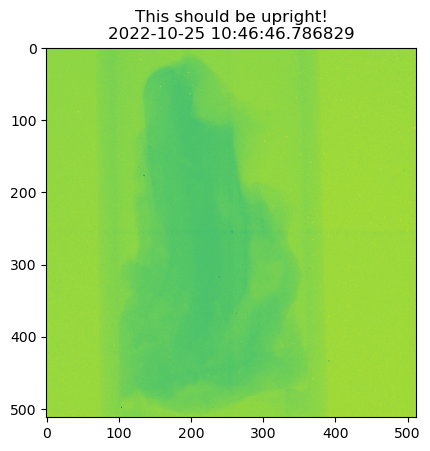

In [4]:
''' Flip in both axes for the Legoman_al_filter_100_um_ datasets... 
Going from (2,3,0,1) to (0,1,2,3) '''

if chip_indices == (0,1,2,3):
    spectral_projs_th0 = np.flip(np.flip(spectral_projs_th0, axis=2), axis=3)
    spectral_open_th0  = np.flip(np.flip(spectral_open_th0, axis=2), axis=3)
    spectral_projs_th1 = np.flip(np.flip(spectral_projs_th1, axis=2), axis=3)
    spectral_open_th1  = np.flip(np.flip(spectral_open_th1, axis=2), axis=3)
plt.title(f'This should be upright!\n{datetime.datetime.now()}')
plt.imshow(np.log(spectral_projs_th0[0,0,:,:]))
plt.show()

In [5]:
open_mean_th0_all_dacs = np.mean(spectral_open_th0, axis=1)
open_mean_th1_all_dacs = np.mean(spectral_open_th1, axis=1)

# plot_image(open_mean_th0_all_dacs[0])
# plt.hist(open_mean_th0_all_dacs[0].flatten(),bins=1000)
# plt.yscale('log')
# plt.show()
open_mean_th0_all_dacs /= exp_time[:,np.newaxis ,np.newaxis]
open_mean_th1_all_dacs /= exp_time[:,np.newaxis ,np.newaxis]

# plot_image(open_mean_th0_all_dacs[0])
# plt.hist(open_mean_th0_all_dacs[0].flatten(),bins=1000)
# plt.yscale('log')
# plt.show()

spectral_projs_th0 /= exp_time[:,np.newaxis ,np.newaxis,np.newaxis]
spectral_projs_th1 /= exp_time[:,np.newaxis ,np.newaxis,np.newaxis]

# plot_image(-np.log(spectral_projs_th0[0,0]))
# plt.hist(spectral_projs_th0[0,0].flatten(),bins=1000)
# plt.yscale('log')
# plt.show()

In [6]:
# print(spectral_projs_th0.shape)

# _global_detector_shift_y = s.find_optimal_offset(gReconParams, spectral_projs_th0[1, :, :, :], angles, detector_x_offsets, detector_y_offsets, stage_offset=0, search_range=20)
# print(_global_detector_shift_y)
# global_detector_shift_y=0.12
results_folder = os.path.join(base_folder, 'results')
if not os.path.exists(results_folder):
    os.makedirs(results_folder)

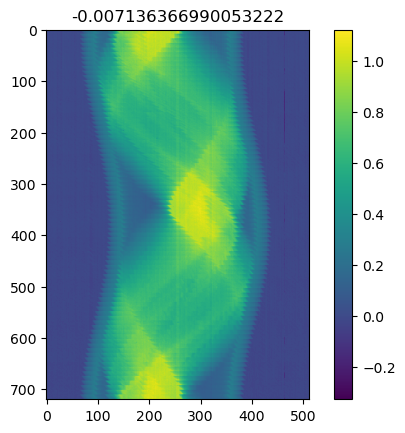

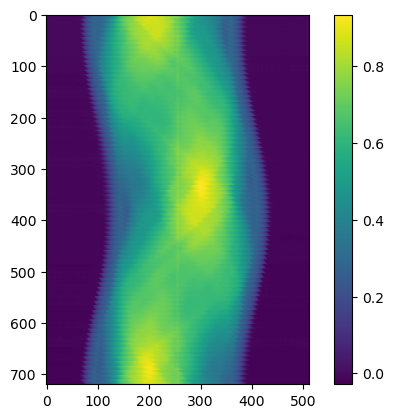

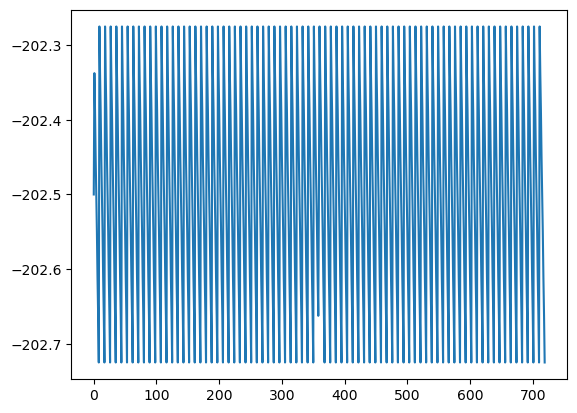

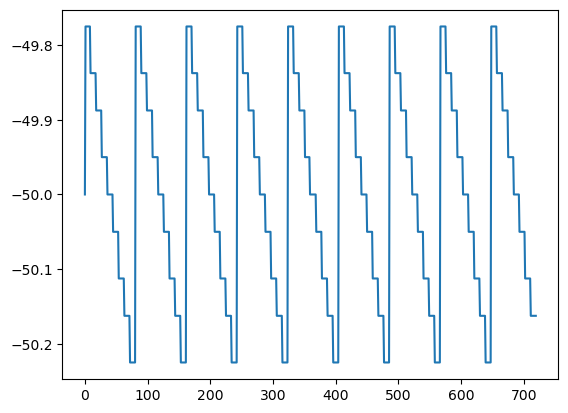

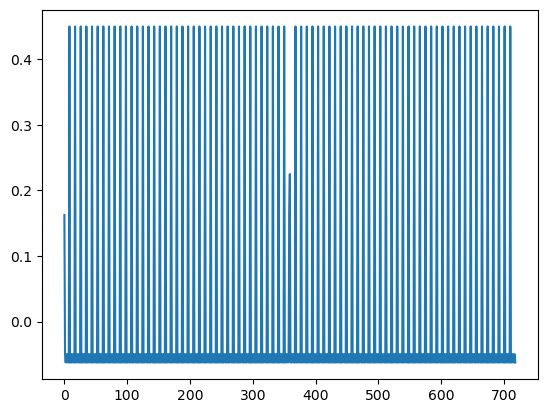

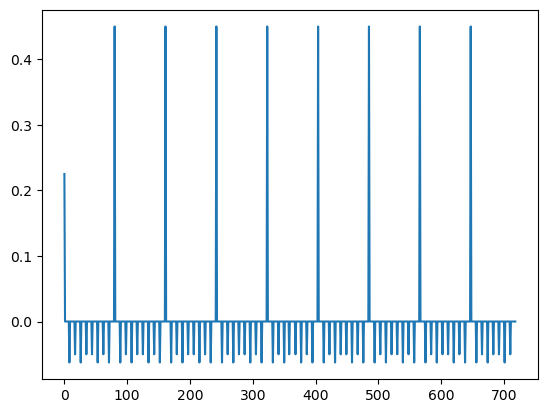

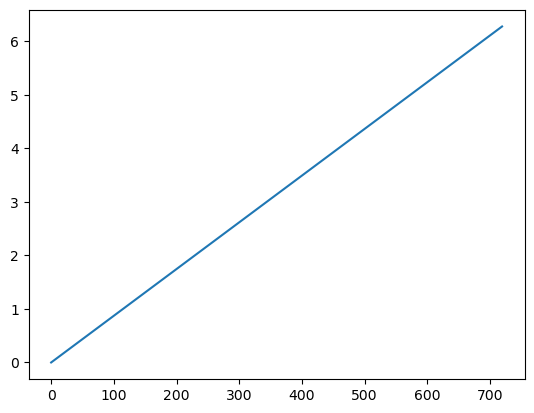

9.81634804233779
-1.0910067923272029


Exception: Reconstuction failed, output was all zeros!!!

In [7]:
ofc_quick = -np.log(spectral_projs_th0[0] / open_mean_th0_all_dacs[0])
plt.title(np.median(ofc_quick[0:10,150,0:10]))
plt.imshow(ofc_quick[:,150,:])
plt.colorbar()
plt.show()
plt.imshow( np.mean(ofc_quick, axis=1))
plt.colorbar()
plt.show()

plt.plot(detector_x_offsets)
plt.show()
plt.plot(detector_y_offsets)
plt.show()

plt.plot(np.diff(detector_x_offsets))
# plt.xlim(len(detector_x_offsets)//2 - 20, len(detector_x_offsets)//2 + 20)
plt.show()
plt.plot(np.diff(detector_y_offsets))
# plt.xlim(len(detector_y_offsets)//2 - 20, len(detector_y_offsets)//2 + 20)
plt.show()
plt.plot(angles)
plt.show()

ofc_quick = np.nan_to_num(ofc_quick)
# ofc_quick = np.clip(ofc_quick, a_min=0, a_max=4)
print(np.max(ofc_quick))
print(np.min(ofc_quick))


img_th0, geo = s.recon_scan(gReconParams, ofc_quick, angles, detector_x_offsets,
                         detector_y_offsets, centre_of_rotation_offset_x_mm, centre_of_rotation_offset_y_mm, True)
print(geo)
    
plot_image(img_th0[0], title='Recon 0')
plot_image(img_th0[:,0,:], title='Recon 1')
plot_image(img_th0[:,:,0], title='Recon 2')

ni_img = s.make_Nifti1Image(img_th0, geo.dVoxel)
s.save_array(results_folder, 'Recon_th0_OFC_quick.nii', ni_img)

In [ ]:

h = gReconParams['pixels']//2
polyorder = 2

regressions_0, residuals_0 = s.fit_proj_data_values_polynomial(spectral_projs_th0[:,:,:h, :h ], th0_dacs_list[:, 0],polyorder) # TL
regressions_1, residuals_1 = s.fit_proj_data_values_polynomial(spectral_projs_th0[:,:,:h,  h:], th0_dacs_list[:, 1],polyorder) # TR
regressions_2, residuals_2 = s.fit_proj_data_values_polynomial(spectral_projs_th0[:,:, h:, h:], th0_dacs_list[:, 2],polyorder) # BR
regressions_3, residuals_3 = s.fit_proj_data_values_polynomial(spectral_projs_th0[:,:, h:,:h ], th0_dacs_list[:, 3],polyorder) # BL

proj_data_fits =np.zeros((polyorder+1,spectral_projs_th0.shape[1], spectral_projs_th0.shape[2], spectral_projs_th0.shape[3]))

proj_data_fits[:,:,:h, :h ] = regressions_0
proj_data_fits[:,:,:h,  h:] = regressions_1
proj_data_fits[:,:, h:, h:] = regressions_2
proj_data_fits[:,:, h:,:h ] = regressions_3

proj_data_fit_residuals =np.zeros((spectral_projs_th0.shape[1], spectral_projs_th0.shape[2], spectral_projs_th0.shape[3]))
proj_data_fit_residuals[:,:h, :h ] = residuals_0
proj_data_fit_residuals[:,:h,  h:] = residuals_1
proj_data_fit_residuals[:, h:, h:] = residuals_2
proj_data_fit_residuals[:, h:,:h ] = residuals_3
# sitk.WriteImage(sitk.GetImageFromArray(proj_data_fits[0,:,:,:]), os.path.join(results_folder, 'regressions_0.nii'))
# sitk.WriteImage(sitk.GetImageFromArray(proj_data_fits[1,:,:,:]), os.path.join(results_folder, 'regressions_1.nii'))
# sitk.WriteImage(sitk.GetImageFromArray(proj_data_fits[2,:,:,:]), os.path.join(results_folder, 'regressions_2.nii'))


# sitk.WriteImage(sitk.GetImageFromArray(proj_data_fit_residuals), os.path.join(results_folder, 'regressions_residuals.nii'))

In [ ]:
plot_image(proj_data_fits[0,0], vmin=0.075, vmax=.14)
plt.hist(proj_data_fits[0,0].flatten(),bins=1000)
plt.yscale('log')
plt.show()

# plot_image(proj_data_fits[1,0])
# plt.hist(proj_data_fits[1,0].flatten(),bins=1000)
# plt.yscale('log')
# plt.show()

# plot_image(proj_data_fits[2,0])
# plt.hist(proj_data_fits[2,0].flatten(),bins=1000)
# plt.yscale('log')
# plt.show()

plot_image(proj_data_fit_residuals[0], vmin=0, vmax=3000)
plt.hist(proj_data_fit_residuals[0].flatten(),bins=1000)
plt.yscale('log')
plt.show()

In [ ]:
# plot_image(proj_data_fits[0,0])
# plot_image(proj_data_fits[0,:,0,:])
# plot_image(proj_data_fits[0,:,:,0])

# plot_image(proj_data_fit_residuals[0])
# plot_image(proj_data_fit_residuals[:,0,:])
# plot_image(proj_data_fit_residuals[:,:,0])

In [ ]:
print(regressions_0.shape)

N = 1
'''Change the N at least 2 times between 0 and 255 to make sure the fit for other pixels are not SHEIIET'''
x = th0_dacs_list[:, 0]
if polyorder == 2:
    y = (regressions_0[0,0,N,N]*x**2) + (regressions_0[1,0,N,N]*x) + regressions_0[2,0,N,N]
else:
    y = (regressions_0[0,0,N,N]*x) + regressions_0[1,0,N,N]
print(regressions_0[:,0,N,N])
# print()
plt.title('Does it look like a GOOD FIT??????')
plt.plot(x, spectral_projs_th0[:,0,N,N])
plt.plot(x,y)
plt.show()
# print(regressions_2[2,0,N,N])

In [ ]:
# ni_img = nib.Nifti1Image(spectral_projs_th0[0,:,:,:], np.eye(4)) # Do not change this to make_nifti1Image function as we do not need the geo params for this
# s.save_array(results_folder, 'Proj_th0_'+str(th0_list[0])+'proj_org.nii', ni_img)

# for i in range (spectral_projs_th0.shape[0]):
#     print(i, np.mean(spectral_projs_th0[i,:,:,:]))
#     print(i, np.count_nonzero(spectral_projs_th0[i,:,:,:] == 0))

In [ ]:
''' Does this selected region contain only air over the whole scan? '''
air_column_number = 30

img_check = np.nanmedian(spectral_projs_th0[0]/np.nansum(spectral_open_th0[0], axis=0), axis=1)
plt.imshow(img_check)
plt.axvline(0, c='k')
plt.axvline(air_column_number, c='r')
plt.axvline(gReconParams['pixels'] - air_column_number, c='r')
plt.axvline(gReconParams['pixels'], c='k')
plt.show()

# plt.hist(img_check.flatten(), bins=200)
# plt.show()

In [ ]:
print('Finding best DAC values per pixel...')    

# E.g. shape = (21, 512, 512)
corrected_DAC_values_from_open_images = s.save_and_or_load_npy_files(
        results_folder, f'all_dac_values.npy', lambda: s.generate_correct_dac_values(gReconParams, open_mean_th0_all_dacs, th0_dacs_list, chip_indices, plot=True, poly_order=2, open_img_path=results_folder))

'''
for t in scanned_thresholds:
    for p in projections:
        x = get correct dac for this pixel
        f = fit / interpolate for this pixel, using projection data
        y = f(x) --- get corresponding y value for that x
        img[t,p,i,j] = y
'''
for dac_index in trange(0, spectral_projs_th0.shape[0]):
    d = corrected_DAC_values_from_open_images[dac_index] # (512, 512)
    corrected_dacs_from_open_images_for_n_projections = np.repeat(d[np.newaxis, :, :], spectral_projs_th0.shape[1], axis=0).flatten() # (Projections, x/y, y/x) FLATTENED
    proj_data_fits_flat = proj_data_fits.reshape(proj_data_fits.shape[0], -1) # Transpose and flatten projection data
    if polyorder == 2:
        reconstructed_proj_data_flat = (proj_data_fits_flat[0, :]*corrected_dacs_from_open_images_for_n_projections**2) + \
                                        (proj_data_fits_flat[1, :]*corrected_dacs_from_open_images_for_n_projections**1) + \
                                        proj_data_fits_flat[2, :] 
    else:
        reconstructed_proj_data_flat = (proj_data_fits_flat[0, :]*corrected_dacs_from_open_images_for_n_projections**1) + \
                                        proj_data_fits_flat[1, :] 
                                        

    corrected_projection_data = reconstructed_proj_data_flat.reshape(spectral_projs_th0.shape[1], spectral_projs_th0.shape[2], spectral_projs_th0.shape[3])
    s.save_array(results_folder, 'Projections_th0_' + str(th0_list[dac_index])+'_DAC.npy', corrected_projection_data)
    
    median = (np.nanmedian(corrected_projection_data[:, :, 0:air_column_number]) + np.nanmedian(corrected_projection_data[:, :, gReconParams['pixels']-air_column_number:gReconParams['pixels']]))/2
    ofc = -np.log(corrected_projection_data/median)
    # print(f'ofc.shape = {ofc.shape}')
    # plt.imshow(ofc[0, :, :])
    # plt.show()
    # plt.imshow(ofc[62, :, :])
    # plt.show()
    # plt.imshow(ofc[125, :, :])
    # plt.show()
    s.save_array(results_folder, 'projs_th0_'+str(th0_list[dac_index])+'OFC_interp.npy', ofc)

    ofc_bpc = s.save_and_or_load_npy_files(results_folder, f'th{dac_index}_bpc.npy', lambda: s.generate_bad_pixel_corrected_array(ofc, gReconParams))

    # ofc_bpc[271] = 0
    # ofc_bpc[:,281,:] = 0
    # ofc_bpc[:,:,220] = 0

    plot_image(ofc_bpc[0], title='OFC BPC 0')
    plot_image(ofc_bpc[:,0,:], title='OFC BPC 1')
    plot_image(ofc_bpc[:,:,0], title='OFC BPC 2')

    # print(f'ofc_bpc.shape = {ofc_bpc.shape}')
    # plt.imshow(ofc_bpc[0, :, :])
    # plt.show()

    # if dac_index == 0:
    #     stage_offset =  0.325
    # else:
    #     stage_offset = centre_of_rotation_offset_x_mm 
    print('Doing find_optimal_offset!')
    # TODO s.find_optimal_offset is being updated with Jasper's fixes...
    centre_of_rotation_offset_x_mm = 0.1 #s.find_optimal_offset(gReconParams, ofc_bpc, angles, detector_x_offsets, detector_y_offsets, stage_offset=stage_offset, search_range=20)
    print('DAC:{}, centre_of_rotation_offset_x_mm: {}'.format(dac_index, centre_of_rotation_offset_x_mm))
    print('Doing recon finally!')
    img_th0, geo = s.recon_scan(gReconParams, ofc_bpc, angles, detector_x_offsets,
                         detector_y_offsets, centre_of_rotation_offset_x_mm, centre_of_rotation_offset_y_mm, True)
    
    plot_image(img_th0[0], title='OFC BPC 0')
    plot_image(img_th0[:,0,:], title='OFC BPC 1')
    plot_image(img_th0[:,:,0], title='OFC BPC 2')
    
    ni_img = s.make_Nifti1Image(img_th0, geo.dVoxel)
    s.save_array(results_folder, 'Recon_th0_'+str(th0_list[dac_index])+'OFC_BPC.nii', ni_img)
    
    # ofc_bpc_mf = s.median_filter_projection_set(ofc_bpc, 3)
    # img_th0, geo = s.recon_scan(gReconParams, ofc_bpc_mf, angles, detector_x_offsets,
    #                      detector_y_offsets, centre_of_rotation_offset_x_mm, centre_of_rotation_offset_y_mm, True)
    # ni_img = s.make_Nifti1Image(img_th0, geo.dVoxel)
    # s.save_array(results_folder, 'Recon_th0_'+str(th0_list[dac_index])+'OFC_BPC_MF3.nii', ni_img)

In [ ]:
print(centre_of_rotation_offset_x_mm)
centre_of_rotation_offset_x_mm = s.find_optimal_offset(gReconParams, ofc_bpc, angles, detector_x_offsets, detector_y_offsets, stage_offset=0, search_range=35)

In [ ]:
print(f'th = {dac}, finding optimal offset')
global_detector_shift_y = -.02 #find_optimal_offset(spectral_projs_th0[1, :, :, :], angles, detector_x_offsets, detector_y_offsets, stageoffset=0, searchrange=25)
print(f'global_detector_shift_y = {global_detector_shift_y} (mm)')

ni_img = nib.Nifti1Image(ofc_bpc_mf, np.eye(4))
s.save_array(results_folder, 'Proj_th0_'+str(th0_list[dac])+'OFC_BPC_MF.nii', ni_img)

print('Doing recon finally!')
img_th0 = s.recon_scan(gReconParams, ofc_bpc, angles, z_offset, detector_x_offsets,
                    detector_y_offsets, global_detector_shift_y)

ni_img = nib.Nifti1Image(img_th0, np.eye(4))
s.save_array(results_folder, 'Recon_th0_'+str(th0_list[dac])+'OFC_BPC.nii', ni_img)

img_th0 = s.recon_scan(gReconParams, ofc_bpc_mf, angles, z_offset, detector_x_offsets,
                    detector_y_offsets, global_detector_shift_y)
ni_img = nib.Nifti1Image(img_th0, np.eye(4))
s.save_array(results_folder, 'Recon_th0_'+str(th0_list[dac])+'OFC_BPC_MF.nii', ni_img)
